<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 30 de Noviembre y 3 de Diciembre (13:00 hrs) respectivamente.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

In [2]:
import numpy as np
import keras
import pandas as pd
import time
from urllib.request import urlopen, re
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as Tree
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from pandas.tseries.holiday import USFederalHolidayCalendar
from ipywidgets import interactive
from PIL import Image
from geopy.distance import great_circle

Using TensorFlow backend.


<a id="primero"></a>
## 1. Tipos de fronteras en clasificación

In [3]:
def do_gaussianXOR(n1=250,n2=250):
    rng = np.random.RandomState(0)
    u = 0.5
    std = 0.3 #el ruido se agrega aca
    primer_c = rng.normal(loc=[u,u],scale=std,size=(n1,2))
    segundo_c = rng.normal(loc=[-u,u],scale=std,size=(n2,2))
    tercer_c = rng.normal(loc=[-u,-u],scale=std,size=(n1,2))
    cuarto_c = rng.normal(loc=[u,-u],scale=std,size=(n2,2))
    X_train = np.vstack((primer_c,segundo_c,tercer_c,cuarto_c))
    Y_train = np.hstack((np.zeros(n1),np.ones(n2),np.zeros(n1),np.ones(n2)))   
    X_test = rng.uniform(low=-1.0,high=1.0,size=( (n1+n2),2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    return X_train,Y_train,X_test,Y_test

In [4]:
def visualize_border(model,x,y,title=""):
    fig, axis = plt.subplots(1, 1,figsize=(12, 6))

    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]) #or predict_proba
    Z = Z.reshape(xx.shape)
    Zplot = Z > 0.5

    axis.scatter(x[:,0],x[:,1],s=50,c=y,zorder=10,cmap=plt.cm.winter)
    axis.contour(xx, yy, Z,levels=[-1, 0, 1])
    axis.pcolormesh(xx, yy, Zplot ,cmap=plt.cm.YlGn)
    plt.title(title)
    plt.show()

### A
Construya el conjunto de datos (dataset) y describa el proceso de creación de éstos. Determine cuántos registros contiene cada conjunto y visualı́celos.

In [5]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR()

La función "do_gaussianXOR()" se basa en la creación de datos usando una distribución normal con $\mu$ = 0.5 y $\sigma$ = 0.3, este ultimo es primordial para la creación del conjunto de entrenamiento, ya que es lo que le agrega la dispersión de los datos, donde es posible que los datos no queden dentro de un espacio separable cosa que, para terminos de este trabajo, supondra la busqueda de una técnica que pueda abarcar el entrenamiento y posterior testeo de la mejor manera. Por otro lado, para el conjunto de test fue modelado con una distribución uniforme con $a$ = -1 y $b$ = 1 que modelaría una separación casi perfecta de los datos, pero para terminos de lo aprendido puede resultar dificil de clasificar (o no). Notar además que los output de esta funcion se basan en la operación logica XOR, es decir, 1 si ambos valores son iguales o 0 si son distintos.

(1000, 2)
(1000,)


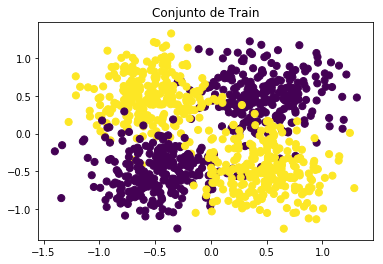

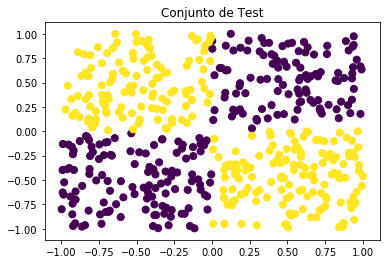

In [16]:
print(X_train.shape)
print(Y_train.shape)
plt.scatter(X_train[:,0], X_train[:,1], s=50, c=Y_train)
plt.title('Conjunto de Train')
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], s=50, c=Y_test)
plt.title('Conjunto de Test')
plt.show()

In [17]:
print(X_train[:15])
print(Y_train[:15])

[[ 1.0292157   0.62004716]
 [ 0.7936214   1.17226796]
 [ 1.0602674   0.20681664]
 [ 0.78502653  0.45459284]
 [ 0.46903434  0.62317955]
 [ 0.54321307  0.93628205]
 [ 0.72831132  0.5365025 ]
 [ 0.63315897  0.6001023 ]
 [ 0.94822372  0.43845252]
 [ 0.59392031  0.24377128]
 [-0.26589694  0.69608558]
 [ 0.75933086  0.27735049]
 [ 1.18092639  0.0636903 ]
 [ 0.51372756  0.44384484]
 [ 0.95983376  0.94080763]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### B
Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Comente cualitativamente lo que observa.

Accuracy under training:  0.502
Accuracy under testing:  0.466


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


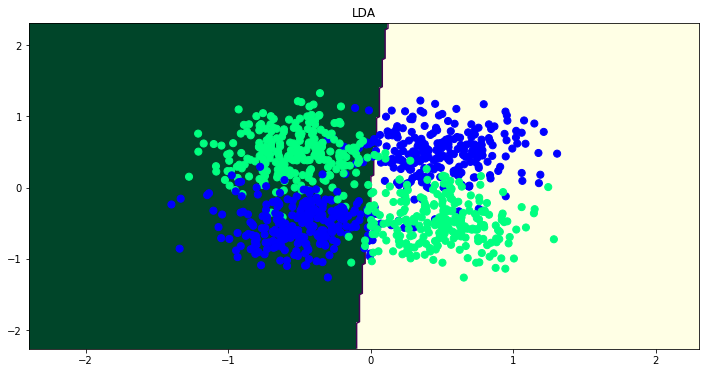

In [18]:
model = LDA()
model.fit(X_train,Y_train)
print("Accuracy under training: ",model.score(X_train, Y_train))
print("Accuracy under testing: ",model.score(X_test, Y_test))
visualize_border(model, X_train, Y_train, "LDA")

Se puede notar que el modelo que obtuvimos divide el conjunto de una manera técnicamente de forma equitativa, sin embargo, hay algunos datos que no deberian pertener a los conjuntos, una de las razones principales puede ser que el clasificador solo permite divisiones lineales y únicas por lo que la solución trata de ajustarse lo más posible. Además como se refiere a una división de datos de manera lineal, esperar un accuracy del 0.5 aprox es normal.

### C
Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribución de probabilidad asumen cada uno?

Accuracy under training:  0.915
Accuracy under testing:  0.978


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


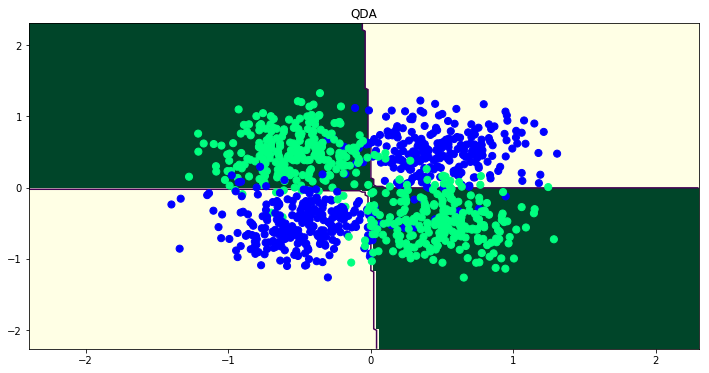

In [19]:
model = QDA()
model.fit(X_train, Y_train)
print("Accuracy under training: ",model.score(X_train, Y_train))
print("Accuracy under testing: ",model.score(X_test, Y_test))
visualize_border(model, X_train, Y_train, "QDA")

Se puede notar que el método resulta ser muy efectivo para conjuntos con una separación muy remarcada, poniendo enfasis que esta separación no es algo lineal, entonces es correcto decir que las fronteras que toma como solución cuadratica, esto a diferencia de LDA tiene una mayor precisión para ciertos casos (este por ejemplo), ya que se nota una gran diferencia entre el desempeño de LDA con QDA, ya que QDA tiene un desempeño de 0.9x tanto como para su conjunto de entrenamiento como para su conjunto de prueba. Se puede notar que aunque QDA y LDA sean dimensionalmente distintos (uno lineal y el otro cuadratico), coinciden parcialmente en que LDA puede dividir el conjunto de la misma manera que QDA, es decir, puede usar la linea horizontal que se ve o la vertical, y ambos para LDA serian una solución, la diferencia es ver cual es mejor entre las dos.

### D
Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) Lineal no puede resolver el problema, para esto construyala a través de sklearn. Mediante la widget interactiva explore diferentes valores del parámetro de regularización $C$ . Analice cualitativamente lo observado, para validar su análisis cualitativo calcule el accuracy sobre el conjunto de pruebas.

In [7]:
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X_train,Y_train)

In [21]:
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='linear')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = -6 #define your range
p_max = 4 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=-1, description='param', max=4, min=-6), Output()), _dom_classes=('widget-interact',))

Se sabe que SVM resuelve problemas que son linealmente separables, es decir, existe un hiperplano separador que divide al conjunto de manera tal que los datos queden a cada lado correspondiente sin que un dato del un lado del plano toque el otro conjunto. Viendo esto visualmente, no existe un parametro C que cumpla el criterio de hiperplano separador (por lo menos en un espacio lineal) ya que se puede notar que existen datos muy mezclados en ambos conjuntos, por lo que separarlos es muy dificil llegando ser imposible.

### E
Demuestre experimentalmente que una Máquina de Vectores de Soporte (SVM) no Lineal puede resolver el problema, para ésto construya una SVM no Lineal a través de un **kernel** [[3]](#refs). Mediante la *widget* interactiva explore diferentes valores del parámetro de regularización $C$ y con diferentes kernels. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [22]:
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='rbf')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 7 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=4, description='param', max=7, min=1), Output()), _dom_classes=('widget-interact',))

Notar que al darle la opción a SVM de ser no lineal, este puede tomar la forma de función cualquiera de tal manera que pueda abarcar la mayor parte de los datos, esto es por que al aplicar un kernel (rbf en este caso) crea un espacio de mayor dimensión donde los datos pueden ser separables (a veces no) por un hiperplano separador, obviamente se quiere hacer esto ya que todavia existen datos que se sobreponen sobre otros, cambiando el kernel solo modifica la manera en que se puede modelar la función del hiperplano separador.

In [68]:
def train_model(param):
    model= SVM()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(C=C,kernel='poly',degree=2)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 7 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=4, description='param', max=7, min=1), Output()), _dom_classes=('widget-interact',))

Independiente que se permitiera a SVM poder realizar funciones polinomiales, este no aumenta la performance esto puede deberse a que al aumentar las dimensiones y obtener una ecuación que separe los datos de manera correcta, al devolverlo a la dimensión original sufra una modificación en la transformación lineal de tal manera que ya no sea posible modelar esa función y por ende bajar su performance en la separación. Notar además que la función a pesar de poder ser polinomial, donde lo correcto seria que en lo posible se modele como cuadratica o algo con orden de los pares, este no lo hace.

### F
Demuestre experimentalmente que un Árbol de Decisión de múltiples niveles puede resolver el problema ¿Qué pasa con un nivel? Para ésto contruya el Árbol de Decisión a través de *sklearn*, puede utilizar el criterio y la función de partición que prefiera. Mediante la *widget* interactiva explore diferentes valores del parámetro de máxima profundidad del árbol. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [24]:
def train_model(param):
    model = Tree()
    C = 10**(param)
    print("Nivel = ", C)
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 40 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=20, description='param', max=40, min=1), Output()), _dom_classes=('widget-interact',))

El significado de los niveles de profundidad, es la cantidad de comparaciones que se deben hacer para poder clasificar un dato, esto generalmente depende de los datos que pueden variar dentro de los datos, para algunos problemas puede ser trivial saber que nivel de profundidad es ideal, pero existen algunos tan complejos que a veces es mejor tantear, para este caso, al probar con los datos, el mejor nivel de profundidad resultó ser entre el 3-4 (ya que abarca la mejor performance), esto tiene mucho sentido ya que los datos tanto en X e Y se pueden separar en 3 o 4 criterios (dependiendo del random de los datos) que son claramente notables en el gráfico.

### G
Demuestre experimentalmente que una red neuronal artificial con 1 capa escondida puede resolver satisfactoriamente el problema. Para esto construya un perceptrón multi-capa, con una capa escondida, variando el número de neuronas $N_h$ a través de la *widget* interactiva. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [8]:
def train_model(param):
    n_h=2**(param)
    print("Neuron hidden = ",n_h)
    model = Sequential()
    model.add(Dense(n_h, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=25, batch_size=128, verbose=0)
    print("Test Accuracy: ",model.evaluate(X_test, Y_test,batch_size=128,verbose=0)[1])
    return model
p_min = 0 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=5, description='param', max=10), Output()), _dom_classes=('widget-interact',))

Se puede notar que aprox con 128 neuronas, el accuracy empieza a ser aceptable y considerablemente bueno, entonces se puede decir que para una mayor cantidad de neuronas ocultas este resultado tiende a ser mejor. Además notar que las fronteras de separación tienden a estar separadas cuadraticamente, donde parece una función $\frac{1}{x}$.

### H
Construya un algoritmo $k$-NN para la clasificación del problema. Mediante la *widget* interactiva explore diferentes valores del parámetro $k$. Discuta el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [26]:
def train_model(param):
    model = KNeighborsClassifier()
    C = 10**(param)
    print("Param C= ",C)
    model.set_params(n_neighbors=param)
    model.fit(X_train,Y_train)
    print("Test Accuracy: ",model.score(X_test,Y_test))
    return model
p_min = 1 #define your range
p_max = 10 #define your range
interactive(visualize_border_interactive,param=(p_min,p_max))

interactive(children=(IntSlider(value=5, description='param', max=10, min=1), Output()), _dom_classes=('widget-interact',))

Para K-NN se sabe que los datos que se concentran en el medio de cada conjunto de datos no tendrán problemas con su clasificación, en los extremos tampoco existe conflicto, en donde se debe enfocar el analisis es en la cruz que se forma en el medio del gráfico visible, ya que hay datos ahí que podrian quedar mal clasificados, algunos pueden llegar a ser inevitables si estan muy sumidos en un conjunto que no les pertenece, sin embargo para los que pueden tener una clara separación si se elige bien el parametro de la cantidad de vecinos a considerar se puede obtener un clasificador decente que pueda tener una alta performance en la clasificación del proximo conjunto de testeo.

### I
Vuelva a generar datos, pero ahora de manera desbalanceada por clase, con más ejemplos en una clase que en otra, pero manteniendo el conjunto de pruebas para verificación. Visualicelo apropiadamente.

In [13]:
X_train,Y_train,X_test,Y_test = do_gaussianXOR(n1=250,n2=5)

(510, 2)
(255, 2)
(510,)
(255,)


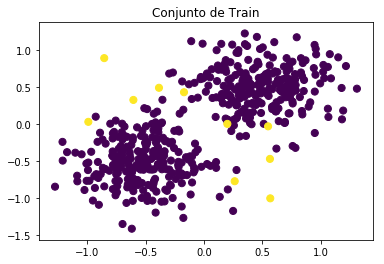

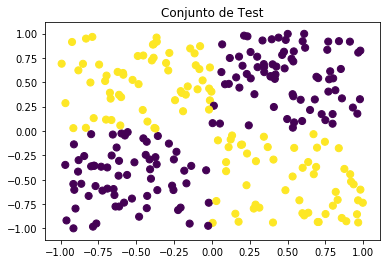

In [14]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
plt.scatter(X_train[:,0], X_train[:,1], s=50, c=Y_train)
plt.title('Conjunto de Train')
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], s=50, c=Y_test)
plt.title('Conjunto de Test')
plt.show()

### J
Escoga las Máquinas de Soporte Vectorial con kernel RBF ($C=1$) o un Árbol de Decisión ($depth=5$) para entrenar sobre estos datos desbalanceados, mida el *Accuracy* sobre el conjunto de pruebas.

Test Accuracy:  0.5568627450980392


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


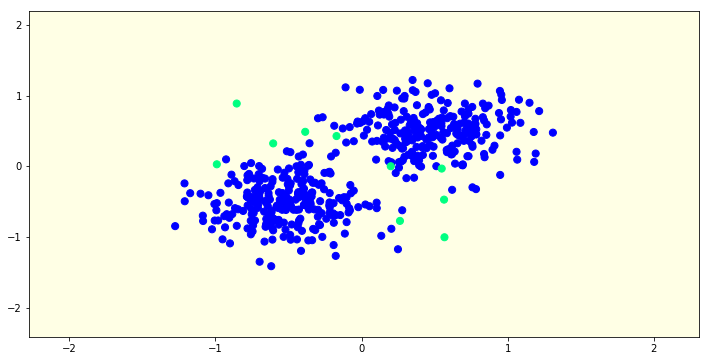

In [18]:
model= SVM()
C = 1
model.set_params(C=C,kernel='rbf')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_train, Y_train)

Test Accuracy:  0.5647058823529412


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


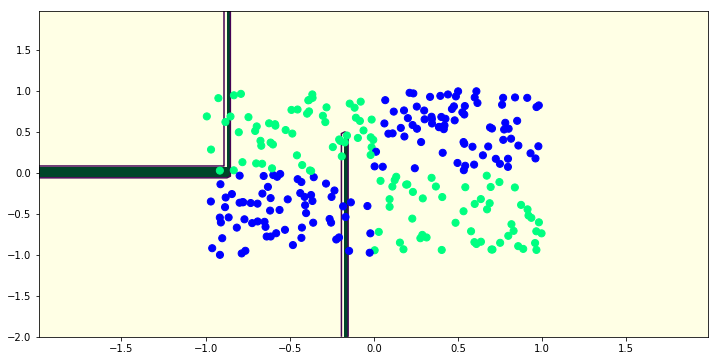

In [19]:
model = Tree()
C = 5
model.set_params(max_depth=C,criterion='gini',splitter='best')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_test, Y_test)

### K
Ahora verifique que se puede mejorar la métrica a través de poner un peso en la función objetivo para las distintas clases, *seteelo* a mano o utilize la función *balanced* para que reduzca el impacto de lo datos de la clase mayoritaria en la función objetivo o que aumente el impacto de los datos de la clase minoritaria.

Test Accuracy:  0.7450980392156863


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


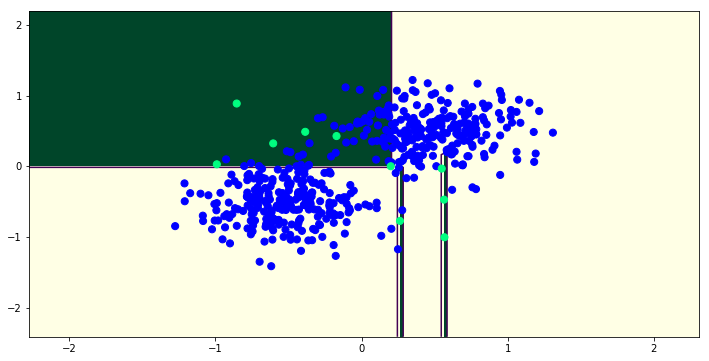

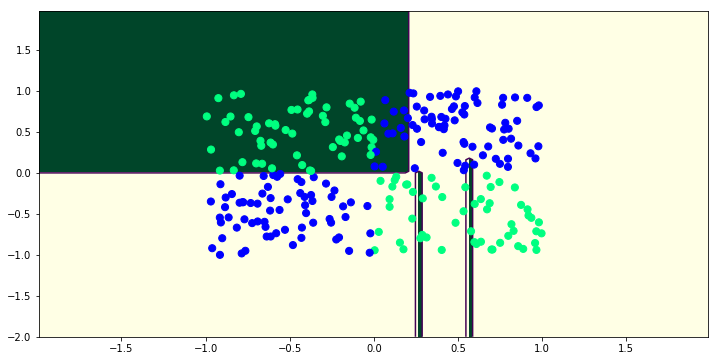

In [20]:
classes_weights = {0: 0.1, 1: 10}
model = Tree()
C = 5
model.set_params(max_depth=C,criterion='gini',splitter='best',class_weight=classes_weights)
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_train, Y_train)
visualize_border(model, X_test, Y_test)

Test Accuracy:  0.7607843137254902


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


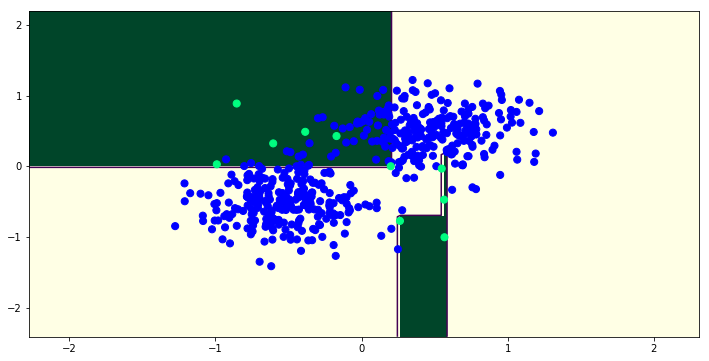

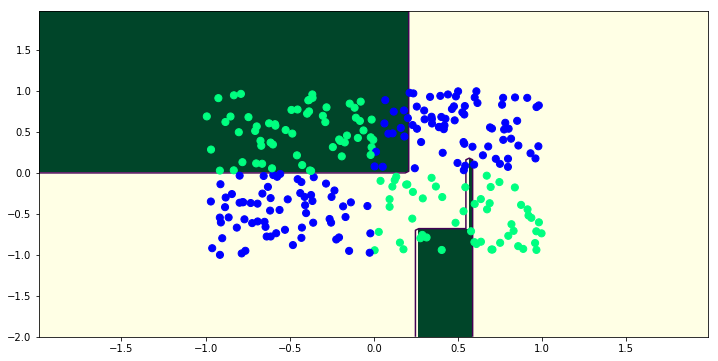

In [21]:
model = Tree()
C = 5
model.set_params(max_depth=C,criterion='gini',splitter='best',class_weight='balanced')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_train, Y_train)
visualize_border(model, X_test, Y_test)

Test Accuracy:  0.8274509803921568


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


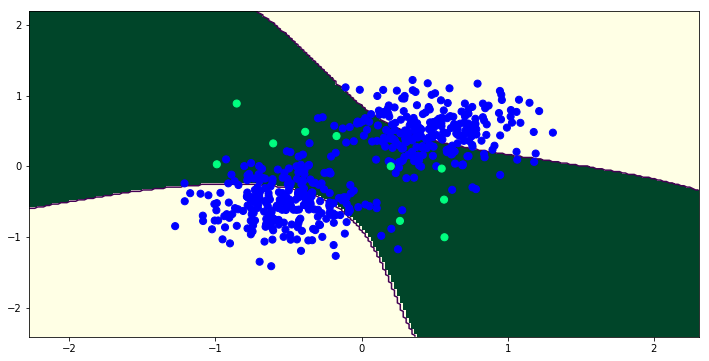

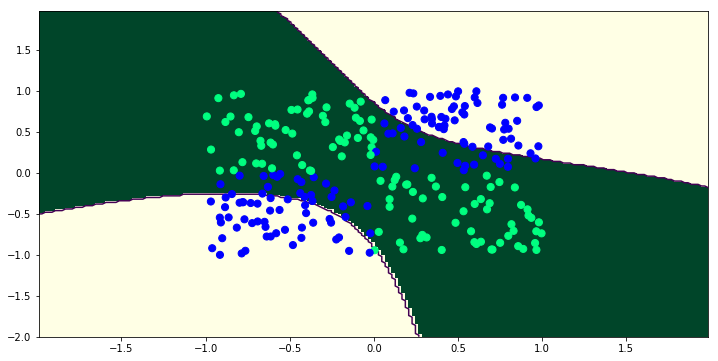

In [22]:
model= SVM()
C = 1
model.set_params(C=C,kernel='rbf',class_weight=classes_weights)
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_train, Y_train)
visualize_border(model, X_test, Y_test)

Test Accuracy:  0.8980392156862745


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


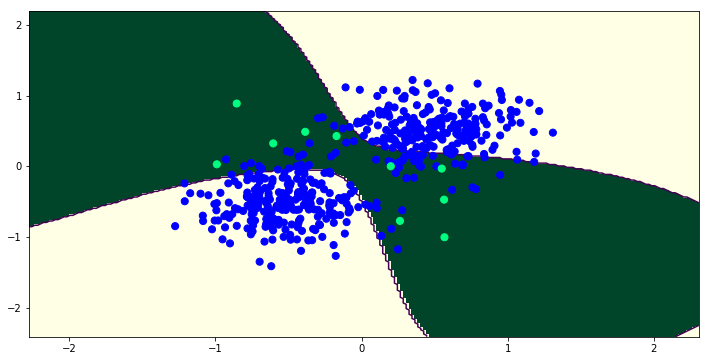

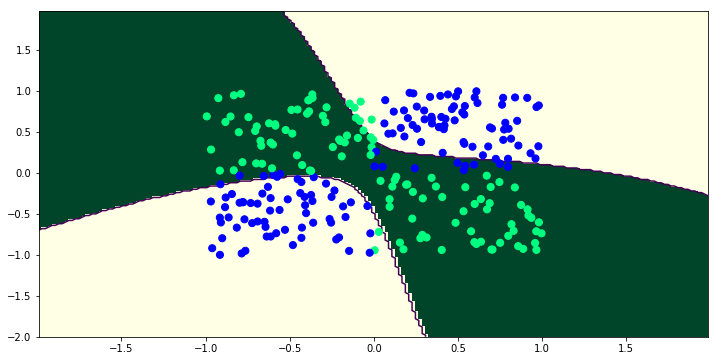

In [24]:
model= SVM()
C = 1
model.set_params(C=C,kernel='rbf',class_weight='balanced')
model.fit(X_train,Y_train)
print("Test Accuracy: ",model.score(X_test,Y_test))
visualize_border(model, X_train, Y_train)
visualize_border(model, X_test, Y_test)

<a id="segundo"></a>
## 2. Un problema* Multi-label*

### A
Cargue los datos del *output* del modelo (*labels*), descríbalos ¿Cuántos ejemplos hay por cada clase?

Cantidad de imagenes: 27807
Cantidad de etiquetas: 81

Cantidad de etiquetas por imagen
0      1474
1      1971
2      1292
3       742
4     10344
5      6143
6      3385
7      1632
8       617
9       161
10       40
11        3
12        2
13        1
dtype: int64

Etiquetas mas frecuentes
sky       19052
clouds    15538
water     11019
lake       5758
grass      4933
dtype: int64


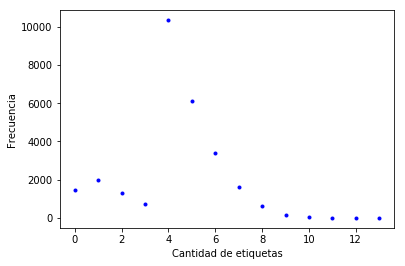

In [25]:
label_names = np.loadtxt("Concepts81.txt",dtype='object')
y = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_groundtruth/Lite_GT_Train.txt",delimiter="\s+",header=None).values
dicc = {}
lista = []
sin_etiquetas = []
for i in label_names:
    dicc[i] = 0
    lista.append(0)
for i in y:
    pos = np.where(i == 1)[0]
    if(len(pos) == 0):
        sin_etiquetas.append(pos)
    lista[len(pos)] += 1
    for j in pos:
        dicc[label_names[j]] += 1
df = pd.Series(data=dicc)
data = pd.Series(data=lista[:14])
print("Cantidad de imagenes: {0}".format(y.shape[0]))
print("Cantidad de etiquetas: {0}".format(y.shape[1]))
print('\nCantidad de etiquetas por imagen')
print(data)
print('\nEtiquetas mas frecuentes')
print(df.nlargest(5))
plt.xlabel('Cantidad de etiquetas')
plt.ylabel('Frecuencia')
plt.plot(data, 'b.')

### B
Visualice el tema de que un dato  (imagen en este caso) puede tener múltiples etiquetas. Comente sobre la definición del problema *multi-label* y cómo aplica en este caso.

Etiquetas de la imagen : []


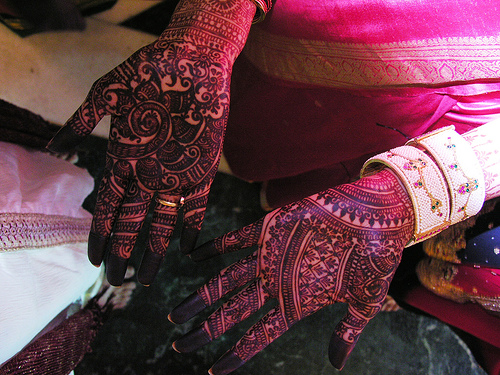

In [38]:
label_names = np.loadtxt("Concepts81.txt",dtype='object')
arch = open("NUS-WIDE-urls.txt",'r')
regex = re.compile("\s+")
image2url = {}
for line in arch.readlines():
    aux = regex.split(line.strip())
    image = aux[0].split("Flickr\\")[-1]
    url_m = aux[3]
    image2url[image] = url_m
arch.close()
arch = open("NUS-WIDE-Lite/image list/Train_imageOutPutFileList.txt",'r')
data_urls = [image2url[line.strip()] for line in arch.readlines()]
arch.close()
"""Visualizacion"""
from PIL import Image
s = np.random.randint(0,len(data_urls))
category_sample = np.where(y[s]==1)[0]
print("Etiquetas de la imagen :",label_names[category_sample])
im = Image.open(urlopen(data_urls[s]))
im

Un problema multi-label se dice cuando un dato puede tener multiples etiquetas, es decir, para un "X" puede tener multiples "Y". Por ejemplo, como se puede ver arriba, las imagenes que se muestran (No todas, ya que existen 1474 que no poseen etiquetas y otras 1971 que solo tienen una etiqueta) pueden tener multiples etiquetas dependiendo de su contenido com imagen y como fueron esas clasificadas. (Véase el item A para ver las cantidades esperables)

### C
Comente sobre la **representación** que posee la salida de los modelos (*labels*) ¿En qué dominio habita? ¿Tiene restricciones?

Estas etiquetas representan un texto que describe una figura la cual existe en la data, hay casos donde no necesariamente eso ocurre, es decir, puede existir el descriptor en la imagen (viendo la imagen y conociendo las etiquetas existentes) pero no esta marcado, donde una solución seria agregarla viendo todas las imagenes, otra solución puede ser separar esas imagenes (vistas anteriormente) y hacer que el learner lo duduzca, asi como un conjunto de validación.

Luego de hablar sobre que representa cada etiqueta, el dominio queda limitado a las etiquetas ya existentes, por que técnicamente no es posible asignar un valor nuevo de tal manera que se pueda entender, en otras palabras, asi como esta el dominio, es muy complicado por no decir imposible, lo que se puede hacer quizá, es pasarlos a un valor numerico de tal manera que se pueda interpretar más facil.

### D
Decida sobre una **representación**, en este caso descriptores, para la entrada a los modelos (*input*), puede utilizar la mezcla entre distintos descriptores, comente sobre la elección y qué representa.

In [39]:
file = "Normalized_CH_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s+",header=None).values
print("Cantidad de imagenes: {0}".format(descriptors.shape[0]))
print("Dimensiones del histograma de color: {0}".format(descriptors.shape[1]))
print("\nEjemplo de un histograma (normalizado) para una imagen: ")
print(descriptors[0])

Cantidad de imagenes: 27807
Dimensiones del histograma de color: 64

Ejemplo de un histograma (normalizado) para una imagen: 
[-0.065481  0.222105  0.021829 -0.14774  -0.151919  0.273581  1.385515
 -0.047434 -0.179808 -0.295423  0.232651  0.241071 -0.007792 -0.076588
  0.158871 -0.160516 -0.153856 -0.123022 -0.013257  0.029004  0.078699
 -0.18941  -0.055155  0.070918  0.066343 -0.145516  0.1002   -0.134145
  0.576507 -0.080124 -0.072175 -0.055192 -0.195248 -0.024621  0.279948
 -0.162855  0.077615 -0.096115 -0.150071 -0.152864 -0.120107  0.152457
 -0.151791  0.064348 -0.022722  0.094903  0.169681 -0.113591 -0.054432
  0.0927    0.055814  0.147327 -0.223402 -0.076589  0.745174 -0.071791
  0.182383 -0.010253 -0.186688  0.012101  0.130636  0.073711 -0.205141
 -0.067124]


El descriptor elegido representa una histograma de colores de 64 dimensiones, esto es una forma de representar imagenes de una manera numerica y mejor entendible para entrenar, esta técnica es mejor descrita en [[8]](#refs), la opción de la elección es más que todo por la simplicidad de la técnica y como esta técnica posee una dimensión "pequeña", el tiempo de computo no es tanto. La gracia de estos datos, es que fueron normalizados de la forma:

$$
    N = \frac{X - \mu}{\sigma}
$$

### E
Deje un conjunto separado para evaluar los modelos y comportar como conjunto de pruebas, además de realizar la clásica estandarización de las entradas de los modelos.

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

### F
Se presenta una métrica para validar en el código a continuación, la cual mide la cantidad de aciertos a las *labels* que tenga un dato de manera normalizada. Defina **otra** métrica a utilizar con el propósito de validar lo mismo (el desempeño de un modelo).

In [41]:
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.sum(y==yp, dtype='float')/len(y)
    return suma/float(len(y_true))

def eval_metric(y_true, y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += ((y**2 + yp**2)**(1/2))/len(y)
    return np.sum(suma)/float(len(y_true))

Para la primera metrica, se evalua si los datos son o no iguales, por lo tanto se evalua que tan preciso fue el learner para predecir exactamente el dato.

Para la segunda metrica, se evalua que tan distantes son los datos, es decir una distancia euclidiana sobre los datos, con esto se puede entender que tan lejano es la prediccion.

Se eligió la segunda metrica ya que la primera puede ser muy estricta para la eleccion de igual, por ejemplo, si el valor real es 5 pero la predicción fue de 4,86 humanamente parece que son iguales en cierto rigor, pero para la definicion de la funcion, no lo son.

### G
Experimente en resolver el problema con un Árbol de Decisión (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender de manera sencilla a *multi-label* [[4]](#refs). Mida las métricas de desempeño definidas anteriormente sobre ambos conjuntos (entrenamiento y pruebas), comente.

In [42]:
from sklearn.tree import DecisionTreeClassifier as Tree
model = Tree() 
model.set_params(max_depth = 5,criterion = 'entropy',splitter = 'best')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [43]:
inicio = time.time()
print('Valor obtenido por la metrica (1): {0}'.format(evaluation_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (1): 0.9566939355904682
Tiempo de ejecución: 0.16614007949829102


In [44]:
inicio = time.time()
print('Valor obtenido por la metrica (2): {0}'.format(eval_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (2): 0.06584141465621762
Tiempo de ejecución: 0.1797959804534912


Como fue dicho anteriormente, la idea de aplicar la segunda metrica es ver que tan lejano pueden llegar a ser los datos, el problema de la aplicación es que no es precisa para datos de tipo outlier pero fuera de eso, puede decir que tan buena fue la predicción mientras mas cercana a 0 está.

Como se puede ver, la precisión de la primera metrica dice que el 95% de los datos son iguales, es un numero bastante aceptable, por otro lado, el valor obtenido en la segunda metrica es 0.06 que básicamente dice que la distancia en promedio de datos por columna, es muy baja.

Por otro lado, los tiempos de ejecución para ambas metricas, para una cantidad de datos como el del dataset son bastante parecidos, con unos pequeños milisegundos de diferencia, por lo que ambas metricas para una cantidad de datos parecidos, deberia ser bueno, sin embargo para datasets de datos en el orden de los millones o mil millones, puede que la segunda metrica sea mas lenta, o quizá para este caso solo fue más lento.

### H
Experimente en resolver el problema con una Máquina de Soporte Vectorial no lineal (varíando los hiper-parámetros estructurales), el cual a través de *sklearn* se puede extender a *multi-label* a través de la técnica **OneVsRest**. Mida las métricas de desempeño al igual que para el Árbol de Decisión, comente y compare sobre las métricas y los tiempos de ejecución.

In [45]:
model= SVM()
model.set_params(C=1,kernel='rbf')
meta_model = OneVsRestClassifier(model)
meta_model.fit(X_train,y_train)
y_pred = meta_model.predict(X_test)

In [46]:
inicio = time.time()
print('Valor obtenido por la metrica (1): {0}'.format(evaluation_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (1): 0.9589836103947539
Tiempo de ejecución: 0.19736695289611816


In [47]:
inicio = time.time()
print('Valor obtenido por la metrica (2): {0}'.format(eval_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (2): 0.06539337928111486
Tiempo de ejecución: 0.2175731658935547


Los valores obtenidos por SVM en comparación con arboles, no son muy distintos de hecho para la metrica (1) tienen aprox la misma precisión, de mismo modo para la segunda metrica por lo que independiente de que modelo se use, se tiende a obtener los mismos resultados, en el sentido de precisión, ya que no se sabe si los datos predichos son en realidad son los mismos.

En cuanto a los tiempos, el modelos de árbol resulta de evaluación y predicción más rápida, en cambio para SVM, el tiempo de espera para lo anterior, fue exageradamente mucho por lo que en cuento a que modelo usar, es preferible hasta el momento árbol.

### I
Experimente en resolver el problema con una Red Neuronal *Feed Forward* (decida el número de capas y el número de neuronas, si desea puede utilizar las por defecto). Éste modelo se extiende a *multi-label* a través de la interfaz de *keras* seleccionando una *loss* adecuada, en este caso **binary cross entropy** ¿Por qué?

In [48]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/40
18630/18630 [==============================] - 1s 61us/step - loss: 0.4537
Epoch 2/40
18630/18630 [==============================] - 1s 33us/step - loss: 0.1806
Epoch 3/40
18630/18630 [==============================] - 1s 35us/step - loss: 0.1552
Epoch 4/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1492
Epoch 5/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1462
Epoch 6/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1441
Epoch 7/40
18630/18630 [==============================] - 1s 33us/step - loss: 0.1426
Epoch 8/40
18630/18630 [==============================] - 1s 35us/step - loss: 0.1413
Epoch 9/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1402
Epoch 10/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1393
Epoch 11/40
18630/18630 [==============================] - 1s 34us/step - loss: 0.1385
Epoch 12/40
18630/18630 [===========================

In [49]:
inicio = time.time()
print('Valor obtenido por la metrica (1): {0}'.format(evaluation_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (1): 0.0
Tiempo de ejecución: 0.1740858554840088


Es importante destacar que el valor de la metrica aquí es 0, esto se pudo dar por que la red neuronal hace una probabilidad de que el dato sea, es decir que tan probable es que la etiqueta x sea parte del dato que se esta trabajando.

In [50]:
inicio = time.time()
print('Valor obtenido por la metrica (2): {0}'.format(eval_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (2): 0.09273731893853648
Tiempo de ejecución: 0.31389689445495605


Para esta red, hacer binary cross entropy es la mejor metrica de loss function ya que en realidad se trabaja con valores binarios, es decir esta o no, por lo que el hecho de tener una metrica de la forma binaria es más acorde a lo que se quiere resolver.

### J
Realice predicciones **probabilísticas** de su modelo ¿Las probabilidades están normalizadas? ¿Por qué? Además defina una forma para pasar de la representación de las probabilidades a la representación de *labels* categoricos definidos como en c).

Antes de poder tomar una decision de como decidir los labels, hay que ver los datos con los que estamos trabajando

In [51]:
print(y_pred[0])

[3.05568241e-02 1.25514328e-01 1.09198250e-01 1.50360074e-03
 2.42232885e-02 9.57560167e-02 7.97020039e-04 1.61494091e-02
 1.11026041e-01 2.08593719e-02 5.53342747e-03 2.76823528e-03
 1.28163686e-02 5.67673445e-01 1.28080277e-03 1.46649638e-02
 9.35779046e-03 6.25556801e-04 1.77557487e-02 3.65514716e-04
 3.39345657e-03 3.34248273e-03 9.85266548e-03 9.23122570e-04
 7.49351783e-03 1.50091632e-03 1.76570052e-03 1.60454232e-02
 3.62197449e-03 3.92150087e-03 4.68951128e-02 7.23259291e-03
 1.09661268e-02 5.56807965e-02 2.43139490e-01 3.66020994e-03
 2.94549100e-04 3.81306075e-02 6.27666246e-03 6.00701012e-02
 9.08688735e-03 2.52061903e-01 1.86131895e-01 5.70529215e-02
 3.51557620e-02 2.67856685e-03 8.07855395e-04 5.34322299e-03
 3.32861394e-03 8.77009034e-02 5.69184832e-02 8.40355679e-02
 1.33147649e-03 1.37493731e-02 2.72700749e-03 5.79696178e-01
 6.60204589e-02 7.47288053e-04 7.37722777e-03 1.45469932e-03
 8.20746925e-03 1.67411081e-02 1.44812344e-02 4.57103644e-03
 6.40703226e-03 8.022253

Se puede ver que los valores rondan \[0,1\] por lo que hay que encontrar un numero para el cual un dato sea aceptado como label, es decir, lo es o no.

In [52]:
def precision(y_pred, y_true):
    suma = 0
    for i in range(len(y_pred)):
        if(y_pred[i] == y_true[i]):
            suma += 1
    return suma/len(y_pred)

listas = []
for i in y_pred[0:5]:
    for j in np.linspace(0.1,1,10):
        lista = []
        for k in i:
            if k > j:
                lista.append(1)
            else:
                lista.append(0)
        listas.append(lista)

In [53]:
for j in range(len(y_test[0:5])):
    for i in range(0,10):    
        print('Valor de aceptacion: {0}; Performance: {1}'.format((i+1)/10 ,precision(y_test[j], listas[(5*j)+i])))
    print('\n')

Valor de aceptacion: 0.1; Performance: 0.9012345679012346
Valor de aceptacion: 0.2; Performance: 0.9629629629629629
Valor de aceptacion: 0.3; Performance: 0.9382716049382716
Valor de aceptacion: 0.4; Performance: 0.9382716049382716
Valor de aceptacion: 0.5; Performance: 0.9382716049382716
Valor de aceptacion: 0.6; Performance: 0.9506172839506173
Valor de aceptacion: 0.7; Performance: 0.9506172839506173
Valor de aceptacion: 0.8; Performance: 0.9506172839506173
Valor de aceptacion: 0.9; Performance: 0.9506172839506173
Valor de aceptacion: 1.0; Performance: 0.9506172839506173


Valor de aceptacion: 0.1; Performance: 0.9382716049382716
Valor de aceptacion: 0.2; Performance: 0.9382716049382716
Valor de aceptacion: 0.3; Performance: 0.9382716049382716
Valor de aceptacion: 0.4; Performance: 0.9382716049382716
Valor de aceptacion: 0.5; Performance: 0.9382716049382716
Valor de aceptacion: 0.6; Performance: 0.8641975308641975
Valor de aceptacion: 0.7; Performance: 0.9629629629629629
Valor de ace

Como se puede ver para los ejemplos, generalmente los valores entre 0.4 y 0.5 las performance resulta la más alta, notar que hay casos que no puede ser así, pero en general la mayoria sigue esta regla. Es por esto que, para hacer la función 'transform', se utilizara la metrica de: dato > 0.5

In [54]:
def transform(y_pred):
    listas = []
    for i in y_pred:
        lista = []
        for j in i:
            if j > 0.5:
                lista.append(1)
            else:
                lista.append(0)
        listas.append(lista)
    return listas

In [55]:
prob_pred = model.predict(X_test)
y_pred = transform(prob_pred)
print(y_pred[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Como fue dicho anteriormente, los datos obtenidos en un prinpicio tienen un dominio entre \[0,1\] esto es por que el learner poner en probabilidades de que tan posible es que la etiqueta pertenezca al dato, es decir, mientras mas cerca del 1, más seguro está de que la etiqueta pertenece al dato en cuestión. Asi que técnicamente estan estan normalizadas por una distribución de probabilidad que para este caso, no es conocida.

### K
Ahora que recuperó la representación de las *labels* mida las métricas de desempeño sobre la Red Neuronal. Compare y comente.

In [56]:
prediccion = transform(model.predict(descriptors))

Etiquetas de la imagen : ['animal' 'birds' 'clouds' 'lake' 'sky' 'sunset']
sky


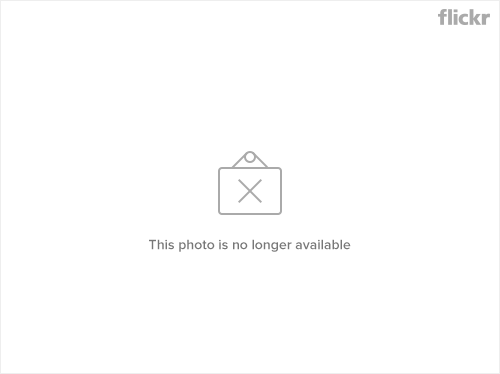

In [57]:
s = np.random.randint(0,len(data_urls))
category_sample = np.where(y[s]==1)[0]
print("Etiquetas de la imagen :",label_names[category_sample])
for i in range(len(prediccion[s])):
    if prediccion[s][i] == 1:
        print(label_names[i])
im = Image.open(urlopen(data_urls[s]))
im

Se puede notar claramente que hay muchos casos donde la red neuronal le faltan muchas etiquetas, esto puede darse por dos efectos que fueron comentados anteriormente.

Primero, para los datos tomados en la sección D son una metrica que no garantiza muchas cosas, como esta técnica de representación de imagenes se basa principalmente en los colores y no en las formas, puede existir mucha confusión por parte de la red que no garantiza que pueda notar formas y como la mayoria de las etiquetas se basan en formas para determinar lo que es, es muy poco probable para esta red entrenada notarlos.

Segundo, en la sección J se eligió un limite de aceptación de las etiquetas, esto pudo traer problemas por la aceptación de las etiquetas en el sentido de, quizá existe una metrica de tal manera que se acepte en mayor cantidad de etiquetas correctas, pero esto no es del todo certero.

Por ultimo, comentar que los set de train y test pueden ser cambiados de una manera mas convencional, por que como se ve en la sección A, existen imagenes sin etiquetas, por lo tanto no es raro pensar hacer de estas imagenes el conjunto de test, para ver si en realidad puede existir alguna etiqueta que los datos tecnicamente no notan.

### Anexo

Se deja en claro que esta sección es para hacer pruebas en variación de parametros para ver como podria obtenerse de mejor resultado lo visto anteriormente y analizar de mucha mejor manera el efecto de los parametros. Queda a criterio del evaluador si tomarlo en cuenta o no.

Esto es hecho por voluntad total de los autores. 

Algo que nos llamo la atención, es que se preguntara sobre la metrica de loss usada en el ejercicio I, que pasaría si cambiamos esta loss function por otra?

In [58]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="mean_squared_error")
model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/40
18630/18630 [==============================] - 1s 40us/step - loss: 0.2065
Epoch 2/40
18630/18630 [==============================] - 1s 28us/step - loss: 0.1017
Epoch 3/40
18630/18630 [==============================] - 1s 28us/step - loss: 0.0564
Epoch 4/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0457
Epoch 5/40
18630/18630 [==============================] - 1s 28us/step - loss: 0.0422
Epoch 6/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0405
Epoch 7/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0395
Epoch 8/40
18630/18630 [==============================] - 1s 28us/step - loss: 0.0389
Epoch 9/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0385
Epoch 10/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0381
Epoch 11/40
18630/18630 [==============================] - 1s 27us/step - loss: 0.0379
Epoch 12/40
18630/18630 [===========================

In [59]:
inicio = time.time()
print('Valor obtenido por la metrica (1): {0}'.format(evaluation_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (1): 0.0
Tiempo de ejecución: 0.15747809410095215


In [60]:
inicio = time.time()
print('Valor obtenido por la metrica (2): {0}'.format(eval_metric(y_test,y_pred)))
print('Tiempo de ejecución: {0}'.format(time.time() - inicio))

Valor obtenido por la metrica (2): 0.09174331161042956
Tiempo de ejecución: 0.17107677459716797


In [61]:
prediccion = transform(model.predict(descriptors))

Etiquetas de la imagen : ['cars' 'person']
sky


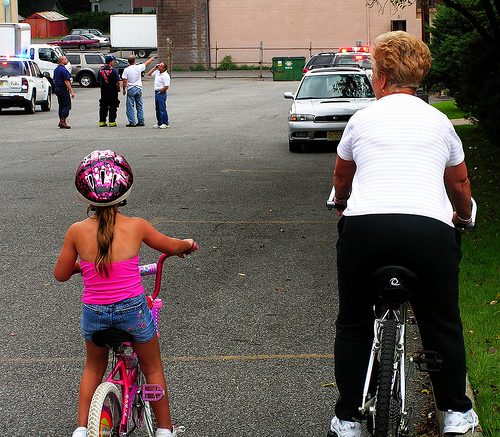

In [62]:
s = np.random.randint(0,len(data_urls))
category_sample = np.where(y[s]==1)[0]
print("Etiquetas de la imagen :",label_names[category_sample])
for i in range(len(prediccion[s])):
    if prediccion[s][i] == 1:
        print(label_names[i])
im = Image.open(urlopen(data_urls[s]))
im

Notar que para los mismos datos y funciones, los valores que se obtienen por cambiar la metrica de loss, son bastante distintos y erroneos ya que en general se obtiene muchas etiquetas que ni visualmente se pueden apreciar.

Otra cosa interesante a destacar, es el dataset 'X' que se eligió. Como fue dicho anteriormente, el histograma de color no es una buena forma de representar imagenes cuando se quiere destacar la forma de ellos, que es basicamente en lo que se enfoca esa actividad, que pasaria si probamos otra forma?

In [63]:
file = "Normalized_CM55_Lite_Train.dat"
descriptors = pd.read_csv("NUS-WIDE-Lite/NUS-WIDE-Lite_features/"+file,delimiter="\s+",header=None).values
print("Cantidad de imagenes: {0}".format(descriptors.shape[0]))
print("Cantidad de bloques por momento de color: {0}".format(descriptors.shape[1]))
print("\nEjemplo de un bloque (normalizado) para una imagen: ")
print(descriptors[0])

Cantidad de imagenes: 27807
Cantidad de bloques por momento de color: 225

Ejemplo de un bloque (normalizado) para una imagen: 
[ 0.177545 -0.084588 -0.300361 -0.119638 -0.113919  0.159027 -0.143603
 -0.161493 -0.135176  0.246798 -0.258361 -0.119362 -0.047804 -0.062693
  0.084641 -0.103801 -0.132584  0.227475  0.199286 -0.12399  -0.166269
  0.20127  -0.016571 -0.184839  0.098759 -0.075149 -0.108321  0.077775
  0.001084 -0.257213  0.093128  0.173786 -0.273731 -0.072936  0.176965
 -0.359859 -0.085163  0.075707 -0.243995 -0.112819  0.242304  0.384603
 -0.315928  0.291974 -0.626111 -0.232356  0.513898 -0.46385   0.036089
  0.208115  0.257833 -0.104554  0.368657 -0.579669  0.242258 -0.216932
 -0.124544  0.062746  0.000945  0.06051  -0.011163 -0.106217  0.185759
  0.296887 -0.366409 -0.070723  0.093233 -0.212304 -0.02936  -0.001333
 -0.236743 -0.034466 -0.161763  0.025291 -0.305736 -0.012328 -0.01259
 -0.319833 -0.216131  0.320214 -0.662919 -0.07749  -0.009122 -0.045505
 -0.364589  0.039983 

In [64]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(descriptors,y,test_size=0.33)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [65]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(y_train.shape[1], activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy")
model.fit(X_train, y_train, epochs=40, batch_size=128, verbose=1)
y_pred = model.predict(X_test)

Epoch 1/40
18630/18630 [==============================] - 1s 56us/step - loss: 0.3599
Epoch 2/40
18630/18630 [==============================] - 1s 39us/step - loss: 0.1490
Epoch 3/40
18630/18630 [==============================] - 1s 38us/step - loss: 0.1407
Epoch 4/40
18630/18630 [==============================] - 1s 42us/step - loss: 0.1374
Epoch 5/40
18630/18630 [==============================] - 1s 52us/step - loss: 0.1353
Epoch 6/40
18630/18630 [==============================] - 1s 41us/step - loss: 0.1336
Epoch 7/40
18630/18630 [==============================] - 1s 41us/step - loss: 0.1322
Epoch 8/40
18630/18630 [==============================] - 1s 39us/step - loss: 0.1310
Epoch 9/40
18630/18630 [==============================] - 1s 44us/step - loss: 0.1299
Epoch 10/40
18630/18630 [==============================] - 1s 45us/step - loss: 0.1290
Epoch 11/40
18630/18630 [==============================] - 1s 41us/step - loss: 0.1282
Epoch 12/40
18630/18630 [===========================

In [66]:
prediccion = transform(model.predict(descriptors))

Etiquetas de la imagen : ['clouds' 'lake' 'mountain' 'plants' 'reflection' 'sky' 'water']
clouds
grass
sky
water


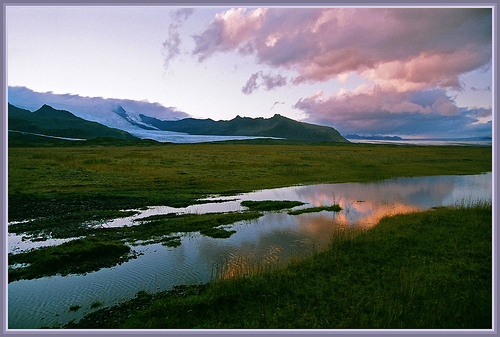

In [67]:
s = np.random.randint(0,len(data_urls))
category_sample = np.where(y[s]==1)[0]
print("Etiquetas de la imagen :",label_names[category_sample])
for i in range(len(prediccion[s])):
    if prediccion[s][i] == 1:
        print(label_names[i])
im = Image.open(urlopen(data_urls[s]))
im

<a id="tercero"></a>
## 3. Taxi Trip Duration: Predicción de duración de viaje

In [3]:
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

### A
Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [4]:
df = pd.read_csv("train.csv")
output = df['trip_duration'].values
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Este dataset contiene 1458644 filas (o datos) y 11 columnas (o variables).

Las columnas son:
- id: Identificador del viaje
- vendor_id: Identificador del conductor
- pickup_datetime: Fecha y hora de recogida
- dropoff_datetime: Fecha y hora de llegada
- passenger_count: Cantidad de pasajeros
- pickup_longitude: Longitud terrestre de la recogida
- pickup_latitude: Latitud terrestre de la recogida
- dropoff_longitude: Longitud terrestre de la llegada
- dropoff_latitude: Latitud terrestre de la llegada
- store_and_fwd_flag: Indica si el registro de viaje se mantuvo en la memoria del vehículo antes de enviarlo al proveedor
- trip_duration: Duración del viaje, la variable que se busca predecir

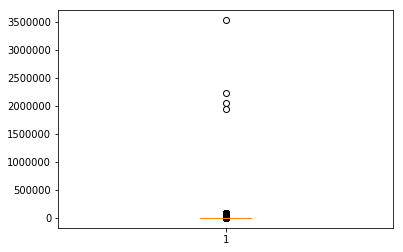

{'boxes': [<matplotlib.lines.Line2D at 0x1a22fe65c0>],
 'caps': [<matplotlib.lines.Line2D at 0x1ad80fcb00>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a62ce7ba8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a62ce7f28>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a22fe6ba8>,
  <matplotlib.lines.Line2D at 0x1ad810b588>]}

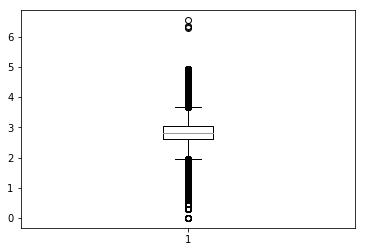

In [105]:
plt.boxplot(output)
plt.show()
plt.boxplot(np.log10(output))

Si bien el gráfico no se comprende mucho, es claro que la duración de los viajes tiene algunos outliers bastante bruscos (3 ordenes de magnitud en comparación de la media), por lo que seria razonable quitarlos de nuestro dataset.

### B
Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

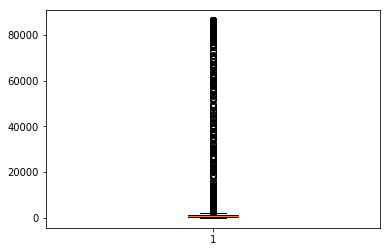

{'boxes': [<matplotlib.lines.Line2D at 0x1a2455ad30>],
 'caps': [<matplotlib.lines.Line2D at 0x1a2455a0f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a2457e668>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a2457eda0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a2455a9e8>,
  <matplotlib.lines.Line2D at 0x1a2455a198>]}

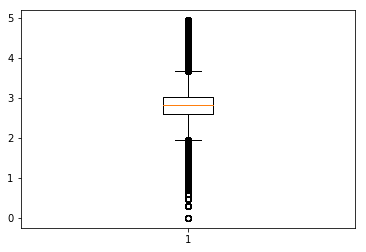

In [106]:
df = df[(df['trip_duration']<=100000)]
output = df['trip_duration'].values
plt.boxplot(output)
plt.show()
plt.boxplot(np.log10(output))

Se puede notar mas claramente en los primeros boxplot que el sacar los datos outliers del dataset, favorece en cierta manera la comprensión de los datos, sin embargo, los datos todavía poseen un boxplot no visible para los datos no linealizados. Para los datos linealizados, en la primera parte no se nota gran diferencia pero para lo que se quiere realizar con el learner será suficiente.

### C
La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hacer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.

In [107]:
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.to_csv("preproceso_taxi.csv", sep=',')
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


<div class="alert alert-info"> **Atención, ejecutar la siguente linea para evitar de nuevo el preprocesamiento.** </div>

In [16]:
df = pd.read_csv("preproceso_taxi.csv")
df = df.drop(df.columns[0], axis=1)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,11,1,1,0.059934,6.385108,200.319835,0,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0


El procesamiento hecho es básicamente para no tener que forzar mucho el computo de datos, ya que en realidad se pasó todos los valores string a numeros, y además se contó con la idea de calcular la distancia euclidiana del viaje, esto es para ver el desplazamiento del vehiculo y ver si estos conlleva alguna información importante para el learner.

### D
Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [17]:
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1021048, 13)
(1021048,)


La elección de un escalamiento estandar, es para trabajar de una manera mas simple e intuitiva. Cuando se revisan los valores de una normalizacion se puede entender a priori cuanto podria ser un valor esperado o que tan relevante es un dato comparado con el resto.

### E
En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation="softsign"))
model.add(Dense(128, activation="softsign"))
model.add(Dense(1, activation="relu"))
model.compile(optimizer=SGD(lr=0.1), loss="poisson")
model.fit(X_train_scaled, y_train, epochs=4, batch_size=256, verbose=1)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test))

In [ ]:
print(y_test[:10])
print(model.predict(X_test_scaled)[:10])

El error resulta ser bastante parecido, ademas de casi tendiendo a un numero bajo, por lo que se puede decir que ambos datos pueden parecerse, quizá con una pequeña diferencia. Lo principal de la predicción es que la diferencia no sea del todo diferente.

### F
Grafique las predicciones generadas por su modelo vs el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

In [ ]:
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))

Que tiene que seguir de alguna forma la recta presente, quizá no de la de mejor manera y no tan intuitiva pero con una densidad de datos más concentrada entorno a esa recta. Los datos obtenidos no reflejan tanto esta recta, aunque los valores sean muy parecidos, puede ser por una mala representación elegida o por que la mala forma de pasar los datos al momento de graficar.

### G
Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento.

In [ ]:
#Quiero hacer un cross validation pero no me sale
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_test_scaled, y_test, cv=5)
scores

<a id="cuarto"></a>
## 4. Entendimiento de imágenes de personas

### A
Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?

In [ ]:
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

Los datos son arreglos de matrices, hay un total de 11 matrices en cada conjunto y cada matriz maneja un diferente conjunto de datos(filas). La de entrenamiento maneja 3500 datos y la testing maneja 1050.

### B
Elija cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo de aprendizaje a utilizar, recuerde que puede utilizar una combinación de éstos si lo desea. Además extraiga las salidas/*output* del problema, en este caso, como ya se comentó, la edad. Describa los datos utilizados y la cantidad de datos por rango de edad.

In [ ]:
X_train = np.array(data_train[0])  #genFeat
Y_train = np.array(data_train[1])  #ageClass
X_test = np.array(data_test[0])  #genFeat
Y_test = np.array(data_test[1])  #ageClass

Se eligió trabajar con gen_feat ya que tiene el mayor potencial para trabajar con las caras, ya que se sintió que las otras categorias no eran suficientes para describir una cara. En cambio gen_feat puede describir la posición de la cara y caracterizticas que relacionan la cara con un vecino.

- xcenter: coord de imagen izquerda a derecha(escalada 0-100)
- ycenter : coord de imagen arriba a abajo(escalada 0-100)
- minSpanningTreeDegree: arbol spanning
- SizeRelativeToNeighbor: >1 es cara mas grande que vecino
- PosX : negativo es vecino a la derecha
- PosY: negativo es vecino abajo de cara
- neiAngle: angulo cara de vecino
- myAngle: angulo de la cara
- x: posicion x promedio
- y: posición y promedio
- Size Relative to Planar FaceFit.: tamaño relativo a lift
- Nearest Neighbor Gender: genero de vecino mas cercano
- NEarest Neighbor Agebin : edad de vecino mas cercano.

Las edades estan trabajadas en rangos, siendo un cierto numero el representante de un cierto rango.

- 1	 es	0-2
- 5	 es	3-7
- 10 es	8-12
- 16 es	13-19
- 28 es	20-36
- 51 es	37-65
- 75 es	66 o mas.

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Hay 3500 datos de training y 1050 datos de testing.

### C
Defina y entrene modelos de aprendizaje para la inferencia de la edad de la persona a través de la representación escogida, *se espera que experimente con distintas configuraciones, modelos e hiper-parámetros* . Intente llegar a un *MSE* menor a 100 sobre la edad de las personas en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.

In [ ]:
import keras
lista=np.zeros((3500,))
y_onehot = keras.utils.to_categorical(lista,num_classes=7)
print(y_onehot)

In [ ]:
model= SVM()
model.set_params(C=0.1,kernel='rbf')
model.fit(X_train,Y_train)
print("Accuracy de training",model.score(X_train,Y_train))
print("Accuracy de testing",model.score(X_test,Y_test))

Como se ve aquí, se produce un overfitting, ya que el modelo se sobreajusta a los datos de entrenamiento, y el accuracy es muy bajo en testing. Se intentará resolverlo usando otro modelo.

In [ ]:
model = Tree()
model.set_params(max_depth=7,criterion='gini')
model.fit(X_train,Y_train)
print("Accuracy de training",model.score(X_train,Y_train))
print("Accuracy de testing",model.score(X_test,Y_test))

Despues de jugar con la altura máxima del arbol, se llego a que la altura 7 entregaba los mejores resultados en terminos de training y testing. Es importante notar que si se aumenta la altura del arbol va a ocurrir una tendencia al overfitting.

In [ ]:
def evaluation_metric(y_true,y_pred):
    suma = 0.
    for y,yp in zip(y_true,y_pred):
        suma += np.sum(y==yp, dtype="float")/len(y)  #cantidad de valores iguales
    return suma/float(len(y_true))

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=SGD(lr=0.1), loss="mean_squared_error")
model.fit(X_train, Y_train, epochs=50, batch_size=256, verbose=0)
print("Evaluación de training",evaluation_metric(Y_train,model.predict(X_train)))
print("Evaluación de testing",evaluation_metric(Y_test,model.predict(X_test)))

La red neuronal realizada no tuvo un buen funcionamiento, debido a que la evaluación de testing y training son muy bajas. Esto puede deberse quizas a la naturaleza de los datos.

Finalmente, luego de probar estos 3 modelos y jugar un poco con sus parámetros, el mejor accuracy obtenido para testing(ya que el de training no importa mucho debido al overfitting) fue de 0.42 aproximadamente.

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html  
[3] https://en.wikipedia.org/wiki/Kernel_method  
[4] http://scikit-learn.org/stable/modules/multiclass.html  
[5] Tsoumakas, G., & Katakis, I. (2007). *Multi-label classification: An overview*. International Journal of Data Warehousing and Mining (IJDWM), 3(3), 1-13.  
[6] https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a  
[7] Bishop, C. M. (2006). *Pattern recognition and machine learning (information science and statistics)* springer-verlag new york. Inc. Secaucus, NJ, USA.  
[8] https://es.wikipedia.org/wiki/Histograma_de_color  